In [1]:
# Exploring the covariance in segregating sites
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
# import warnings
# warnings.filterwarnings('ignore')

import sys
sys.path.append('../../src/')
from plot_utils import *

from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
from patsy import dmatrices
from scipy.stats import linregress
from geopy.distance import geodesic
from num2tex import num2tex

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE : this should be from the plot utils 
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker


f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

import os
main_figdir = '../../plots/hap_copying/jump_rate_chrXdata/'
supp_figdir = '../../plots/supp_figs/hap_copying/jump_rate_chrXdata/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

%matplotlib inline

## Obtaining Raw Statistics from a 1KG Panel

In [3]:
# options for test_panel = (ceu|eur|fullkg)
test_panel = 'ceu'
total_raw_stats_df = pd.read_csv('../../results/hap_copying/chrX_male_analysis/mle_est_real_1kg/chrX_filt.panel_%s.total.ls_stats.csv' % test_panel)
total_raw_stats_df.head()

,indivID,Country,Location,Lat,Long,AvgDate_calBP,Sex,Cov_Autosomes,Data_Type,Publication,Contact,Group_ID,Assessment,snps_per25kb,mle_lambda_jt,mle_eps_jt,mle_lambda_marginal,nsnps,npanel
0,I1137_all_published,Vietnam,Man Bac,20.13333333,105.9833333,3764.0,M,0.136147,1240K,LipsonScience2018,"Pinhasi, Ron",Vietnam_N_all_published,PASS (mtcontam=0.91-0.995),0.380371,736.147360,0.095229,1375.187293,1403.0,49.0
1,I4451_all,Vanuatu,"Efate, Mele-Taplins",-17.689401,168.289509,2260.0,M,1.549016,1240K,LipsonCurrentBiology2018,"Pinhasi, Ron",Vanuatu_2300BP_all,PASS (Xcontam=0.011),3.093750,796.380340,0.036011,1120.203151,11503.0,49.0
2,I1137,Vietnam,Man Bac,20.13333333,105.9833333,3764.0,M,0.102389,1240K,LipsonScience2018,"Pinhasi, Ron",Vietnam_N_published,PASS (mtcontam=0.91-0.981),0.299805,610.076729,0.111014,1311.658256,1112.0,49.0
3,I1781,Turkmenistan,Gonur,38.21228,62.03443,3841.0,M,0.345139,1240K,NarasimhanPattersonScience2019,"Mallory, James; Dubova, Nadezhda",Turkmenistan_Gonur_BA_1,PASS,0.994141,578.708077,0.019025,703.248102,3718.0,49.0
4,I2085,Turkmenistan,Gonur,38.21228,62.03443,3899.0,M,0.130472,1240K,NarasimhanPattersonScience2019,"Mallory, James; Dubova, Nadezhda",Turkmenistan_Gonur_BA_1,PASS (mtcontam=0.978-0.999),0.422607,700.241972,0.036325,1017.481312,1598.0,49.0


In [4]:
# Do a little filtering on the number of snps per kb
snps_kb_threshold = 1
pass_indices = np.array(['PASS' in total_raw_stats_df['Assessment'].values[i] for i in range(total_raw_stats_df.shape[0])])
pass_indivs_raw = total_raw_stats_df.iloc[np.where(pass_indices)[0]]
pass_indivs = pass_indivs_raw[(pass_indivs_raw['snps_per25kb'] >= snps_kb_threshold)]

2.480126462467645 3.2119540161950573 1.549016 1159


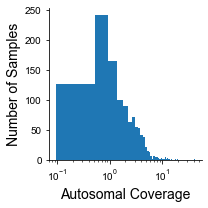

In [5]:
cov_auto = pass_indivs['Cov_Autosomes']
print(np.nanmean(cov_auto), np.nanstd(cov_auto), np.median(cov_auto), cov_auto.size)
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.hist(cov_auto, bins=100);
debox(ax);
ax.set_xscale('log')
ax.set_xlabel(r'Autosomal Coverage', fontsize=14);
ax.set_ylabel(r'Number of Samples', fontsize=14);

In [6]:
mean_age = pass_indivs.groupby('Country').mean()['AvgDate_calBP']
std_age = pass_indivs.groupby('Country').std()['AvgDate_calBP']
min_age = pass_indivs.groupby('Country')['AvgDate_calBP'].min()
max_age = pass_indivs.groupby('Country')['AvgDate_calBP'].max()

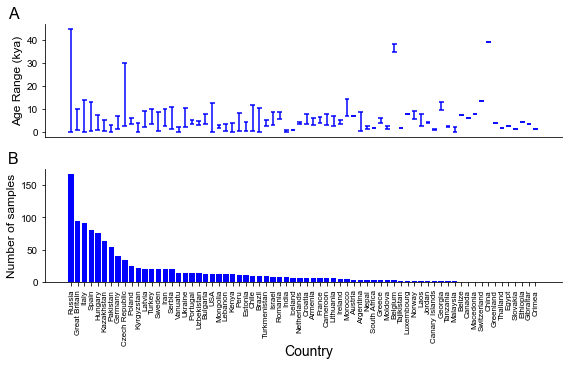

In [7]:
countries, cnts = np.unique(pass_indivs.Country, return_counts=True)
# Return countries in reverse chronological order 
countries_srt = countries[np.argsort(cnts)[::-1]]
cnts_srt = np.sort(cnts)[::-1]

# Make a plot of this information
fig, ax = plt.subplots(2,1,figsize=(8,5))
ax[1].bar(countries_srt, cnts_srt, color='blue')

for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(8);
    
delta=0.35
i = 0
for c in countries_srt:
    cur_min_age = min_age[c]
    cur_max_age = max_age[c]
    ax[0].plot([i,i], [min_age[c]/1e3, max_age[c]/1e3], color='blue', solid_capstyle='butt')
    ax[0].plot([i-delta,i+delta], [min_age[c]/1e3, min_age[c]/1e3], color='blue', solid_capstyle='butt')
    ax[0].plot([i-delta,i+delta], [max_age[c]/1e3, max_age[c]/1e3], color='blue', solid_capstyle='butt')
    i += 1
ax[0].set_xticks([])
ax[0].set_ylabel(r'Age Range (kya)', fontsize=12)
ax[1].set_ylabel(r'Number of samples', fontsize=12)

fig.text(0.5, 0.00, 'Country', fontsize=14)
debox(ax[1]); debox(ax[0]);

for i, label in enumerate(('A', 'B')):
    ax[i].text(-0.05, 1.15, label, fontsize=16, 
               fontweight='bold', va='top', ha='right', transform=ax[i].transAxes);

plt.tight_layout()
plt.savefig(supp_figdir + 'panel_%s_thresh_%d_countries_vs_age.pdf' % (test_panel, snps_kb_threshold), bbox_inches='tight', dpi=300)

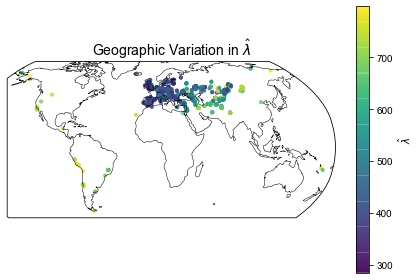

In [8]:
global_lats = pass_indivs.Lat
global_longs = pass_indivs.Long
global_lambda = pass_indivs.mle_lambda_jt
global_age = pass_indivs.AvgDate_calBP

# Some filters here with the distance here  
idx = (global_lats != '..') & (global_longs != '..') & (global_lambda < 8e2)

ax = plt.axes(projection=ccrs.Robinson())
# ax.set_global()
ax.coastlines(lw=0.5)
im = ax.scatter(global_longs[idx].values.astype(float), 
           global_lats[idx].values.astype(float), 
           c=global_lambda[idx].values.astype(float),
           transform=ccrs.PlateCarree(), s=10, alpha=0.75)

# if test_panel == 'ceu':
#     ax.scatter(6., 48, transform=ccrs.PlateCarree(), marker='+', color='red', label=r'CEU Location')
#     ax.legend()

ax.set_title(r'Geographic Variation in $\hat{\lambda}$', fontsize=14)
plt.colorbar(im, label=r'$\hat{\lambda}$')
# plt.show()
plt.savefig(supp_figdir + 'eurasia_panel_%s_global_lambda_%d.pdf' % (test_panel, snps_kb_threshold), bbox_inches='tight', dpi=300)

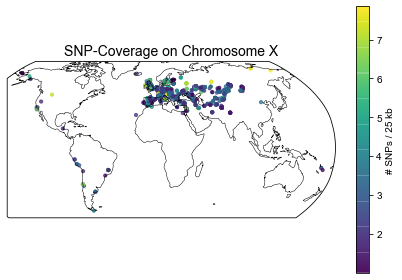

In [9]:
global_lats = pass_indivs.Lat
global_longs = pass_indivs.Long
global_snp_density = pass_indivs.snps_per25kb

# Some filters here with the distance here  
idx = (global_lats != '..') & (global_longs != '..') & (global_lambda < 8e2)

ax = plt.axes(projection=ccrs.Robinson())
# ax.set_global()
ax.coastlines(lw=0.5)
im = ax.scatter(global_longs[idx].values.astype(float), 
           global_lats[idx].values.astype(float), 
           c=global_snp_density[idx].values.astype(float),
           transform=ccrs.PlateCarree(), s=10, alpha=0.75)

# if test_panel == 'ceu':
#     ax.scatter(6., 48, transform=ccrs.PlateCarree(), marker='+', color='red', label=r'CEU Location')
#     ax.legend()
    
ax.set_title(r'SNP-Coverage on Chromosome X', fontsize=14)
plt.colorbar(im, label=r'# SNPs / 25 kb')
# plt.show()
plt.savefig(supp_figdir + 'eurasia_panel_%s_global_snps_%d.pdf' % (test_panel, snps_kb_threshold), bbox_inches='tight', dpi=300)

In [10]:
# Calculate Distance from central europe (ideally add as another annotation)
test_longs = global_longs[idx].values.astype(float)
test_lats = global_lats[idx].values.astype(float)
test_lambda = global_lambda[idx].values.astype(float)
test_ages = global_age[idx].values.astype(float)

assert(test_longs.size == test_lats.size)
assert(test_longs.size == test_lambda.size)

ceu_coords = (48., 6.)
geo_dist_ceu = np.zeros(test_longs.size)
for i in tqdm(range(test_longs.size)):
    geo_dist_ceu[i] = geodesic(ceu_coords, (test_lats[i], test_longs[i])).kilometers
    
# Putting in the distances from CEU coordinates here ... 
dist = np.zeros(pass_indivs.shape[0])
dist[idx] = geo_dist_ceu
pass_indivs['CEU_dist'] = dist

100%|██████████| 979/979 [00:00<00:00, 2818.52it/s]
/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


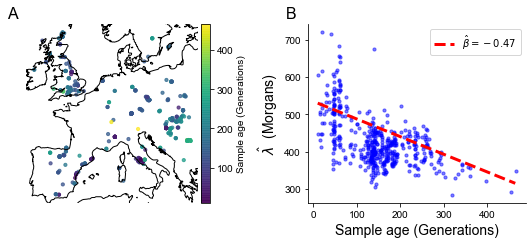

In [11]:
#Do the slight filtering here ... 
km_thresh = 1500
gen_time = 30.
test_df = pass_indivs[(pass_indivs.CEU_dist != 0) & (pass_indivs.CEU_dist <= km_thresh) & (pass_indivs.AvgDate_calBP <= 1.5e4)]
test_df = test_df.astype({'Lat': 'float64', 'Long': 'float64', 'AvgDate_calBP': 'float64', 'Cov_Autosomes': 'float64'})
test_df['AvgDateGenerations'] = test_df.AvgDate_calBP.values / gen_time 

fig = plt.figure(figsize=(7.5,3.5))
gs = fig.add_gridspec(1, 6)


# age_gen = test_df.AvgDateGenerations.values.astype(float)
age_gen = test_df.AvgDateGenerations.values.astype(float)

ax1 = fig.add_subplot(gs[:, :3], projection=ccrs.PlateCarree())
ax1.coastlines(resolution='auto', color='k')
im = ax1.scatter(test_df.Long.values.astype(float), 
           test_df.Lat.values.astype(float),
           transform=ccrs.PlateCarree(), c=age_gen, s=10, alpha=0.75)

fig.colorbar(im, ax=ax1, orientation='vertical', pad=0.01, fraction=0.2, label=r'Sample age (Generations)')

# if test_panel == 'ceu':
#     ax1.scatter(6., 48, transform=ccrs.PlateCarree(), marker='+', color='red', label=r'CEU Assumed Location')
#     ax1.legend(fontsize=8)

ax1.set_aspect('auto')
ax1.outline_patch.set_visible(False)
# debox(ax1);

# Linear Model to check for effect of age 
# NOTE : this accounts for lat/long and their interaction term)
y, X = dmatrices('mle_lambda_jt ~ AvgDateGenerations + Lat + Long + Lat:Long', 
                 data=test_df,
                 return_type='dataframe')

res = sm.OLS(y,X).fit()
intercept = res.params['Intercept']
beta_age = res.params['AvgDateGenerations']
p_value = res.pvalues['AvgDateGenerations']

marginal_lambda = test_df.mle_lambda_jt.values
test_age = np.arange(np.min(age_gen), np.max(age_gen))
pred_lambda = intercept + beta_age*test_age
ax3 = fig.add_subplot(gs[:, 3:])
im2 = ax3.scatter(age_gen, marginal_lambda, c='blue', alpha=0.5, s=10)

legend_str = r"$\hat{\beta} = %0.2f$" % beta_age 
# legend_str += "\n"
# legend_str += r"$p = %s$" % num2tex(p_value, precision=2)
ax3.plot(test_age, pred_lambda, 'r--', lw=3, label=legend_str)
ax3.legend(fontsize=10)
ax3.set_ylabel(r'$\hat{\lambda}$  (Morgans)', fontsize=14)
ax3.set_xlabel(r'Sample age (Generations)', fontsize=14)
debox(ax3);


ax1.text(-0.05, 1.1, 'A', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax1.transAxes);
ax3.text(-0.05, 1.1, 'B', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax3.transAxes);

fig.canvas.draw()
plt.tight_layout()
plt.savefig(main_figdir + 'geography_dist_CEU_thresh_%d_%s_%d.pdf' % (km_thresh, test_panel, snps_kb_threshold), dpi=300)

Text(0, 0.5, '$\\hat{\\lambda}$')

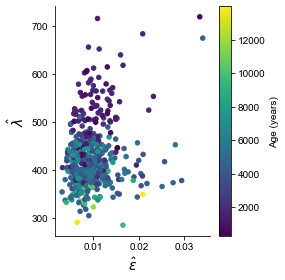

In [12]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
eps_jt = test_df.mle_eps_jt.values
lambda_jt = test_df.mle_lambda_jt.values
age = test_df.AvgDate_calBP.values
im = ax.scatter(eps_jt, lambda_jt, c=age, s=20)
debox(ax);
fig.colorbar(im, label=r'Age (years)');
ax.set_xlabel(r'$\hat{\epsilon}$', fontsize=14)
ax.set_ylabel(r'$\hat{\lambda}$', fontsize=14)

In [13]:
# csv_df = pd.DataFrame({'age_kya':test_df.AvgDate_calBP.values})
# csv_df.to_csv('../../data/hap_copying/chrX_male_analysis/mle_est_real_1kg/ceu_kya_ages.csv', index=False)

## Plotting Jump-Rates Esimated with this time-scale

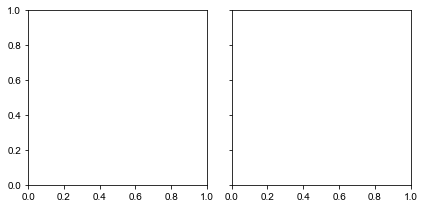

In [14]:
fig,ax = plt.subplots(1,2,figsize=(3*2,3), sharey=True, sharex=True)

# sim_df = pd.read_csv('../../results/hap_copying/simulations/jump_rate_est_sims_ceu_real_chrX.csv')

# mle_scale = []
# model_params  = []
# for f in tqdm(sorted(glob(file_pat))):
#     df = np.load(f)
#     mle_scale.append(df['scale'])
#     model_params.append(df['model_params'])

# mle_scale = np.array(mle_scale)
# model_params = np.vstack(model_params)
# idx = (model_params[:,2] < 500)
# print(np.sum(idx))

# slope, intercept, r_value, p_value, std_err = linregress(model_params[:,2][idx], mle_scale[idx])
# filt_df = sim_df[sim_df.scenario == 'SerialConstant']
# print(filt_df.head())
# ax[0].scatter(, mle_scale[idx], s=10, color='blue', alpha=0.5);
# pred_mle_lambda = model_params[:,2][idx]*slope + intercept
# ax[0].plot(np.sort(model_params[:,2][idx]), 
#            np.sort(pred_mle_lambda), 
#            'r--', label=r'$\hat{\beta} = %0.3f, p = %s$' % (slope, num2tex(p_value, precision=2)))
# ax[0].legend()


# file_pat = '../../../data/hap_copying/mle_results_all/IBDNeUK10K/ceu_sim_%d_X_deCODE/mle_scale_49_Ne10000_0.asc_5.ta_*.scale.npz' % km_thresh

# mle_scale = []
# model_params  = []
# for f in tqdm(sorted(glob(file_pat))):
#     df = np.load(f)
#     mle_scale.append(df['scale'])
#     model_params.append(df['model_params'])

# mle_scale = np.array(mle_scale)
# model_params = np.vstack(model_params)
# idx = (model_params[:,2] < 500)
# slope, intercept, r_value, p_value, std_err = linregress(model_params[:,2][idx], mle_scale[idx])

# ax[1].scatter(model_params[:,2][idx], mle_scale[idx], s=10, color='blue', alpha=0.5);
# pred_mle_lambda = model_params[:,2][idx]*slope + intercept
# ax[1].plot(np.sort(model_params[:,2][idx]), 
#            np.sort(pred_mle_lambda), 
#            'r--', label=r'$\hat{\beta} = %0.3f, p = %s$' % (slope, num2tex(p_value, precision=2)))
# ax[1].legend()

# ax[0].set_ylim(0,1500)
# ax[0].set_title(r'Tennessen et al (2012)', fontsize=14); 
# ax[1].set_title(r'Browning et al (2015)', fontsize=14)
# ax[0].set_ylabel(r'$\hat{\lambda}$', fontsize=14)


# fig.text(0.55, -0.02,   r'Sample age (generations)', fontsize=14, ha='center')
# for i, label in enumerate(('A', 'B')):
#     ax[i].text(-0.05, 1.15, label, fontsize=16, 
#                fontweight='bold', va='top', ha='right', transform=ax[i].transAxes);

# plt.tight_layout()
# debox(ax[0]); debox(ax[1]);
# plt.savefig(supp_figdir + 'sim_mle_lambda_est_CEU_thresh_%d_tennessen_browning.pdf' % km_thresh, bbox_inches='tight', dpi=300);